In [1]:
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt

In [2]:
"""
Read the first tif in ./data/ and prints example information.
"""

import numpy as np
import rasterio

#Dictionary for the bands as they are indexed by rasterio
BANDS = {
    1: 'coastal',
    2: 'blue',
    3: 'green',
    4: 'red',
    5: 'nir',
    6: 'swir1',
    7: 'swir2',
    8: 'thermal1',
    9: 'thermal2'
}

def read_tif(image_file: str) -> np.ndarray:
    """
    Opens an image file and returns a multidimensional numpy array

    Arguments:
        image_file {str}    The location of the image file

    Returns:
        numpy array
    """
    with rasterio.open(image_file, 'r') as src:

        return src.read()

if __name__ == '__main__':
    FILENAME1 = 'data/Peninsular_Malaysia_2016_1_Landsat8.tif'
    FILENAME2 = 'data/Peninsular_Malaysia_2017_1_Landsat8.tif'
    FILENAME3 = 'data/Peninsular_Malaysia_2017_2_Landsat8.tif'
    LANDSAT_IMAGE1 = read_tif(FILENAME1)
    LANDSAT_IMAGE2 = read_tif(FILENAME2)
    LANDSAT_IMAGE3 = read_tif(FILENAME3)


    # You will find some 'holes' in the data, this is where Landsat did not
    # measure a valid surface reflectance in the composites period, due to
    # atmospheric disturbances (clouds). These values are NaN.
    print("\nThe mean {} value of all non clouded areas in Peninsular Malaysia are {} \n".format(
        BANDS[5],
        np.nanmean(LANDSAT_IMAGE1[4])
    ))
    
    print("\nThe mean {} value of all non clouded areas in Peninsular Malaysia are {} \n".format(
    BANDS[5],
    np.nanmean(LANDSAT_IMAGE2[4])
    ))


    print("\nThe mean {} value of all non clouded areas in Peninsular Malaysia are {} \n".format(
        BANDS[5],
        np.nanmean(LANDSAT_IMAGE3[4])))
    
print("The numpy array of a band has the same shape as the image in pixels {} \n".format(
        LANDSAT_IMAGE1[0].shape
    ))
    


The mean nir value of all non clouded areas in Peninsular Malaysia are 0.34789612889289856 


The mean nir value of all non clouded areas in Peninsular Malaysia are 0.3428730368614197 


The mean nir value of all non clouded areas in Peninsular Malaysia are 0.3386590778827667 

The numpy array of a band has the same shape as the image in pixels (850, 1001) 



### Trying to remove the clouds from the images
I had on my mind 2 approaches to remove clouds:

1. Compare between the three images and replace the pixels with nan from image x with the equivalent pixels from image y

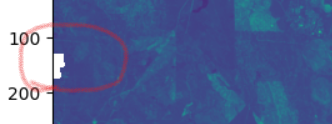 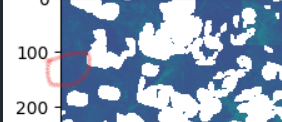

2. The other approach is to loop through n*n part of the matrix and fill the nan pixel if exists with the mean of the other pixels around it 

**Example**

$\begin{matrix} 1 & 2 & 3 \\ 4 & null & 6 \\ 7 & 8 & 9  \end {matrix}   --->  \begin{matrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9  \end {matrix} $


The best one of the two approaches is the second because it will be accurate than the first in terms of deforested areas. Meaning that the first one can take pixels from an area that became deforested and fill it in a non deforested area . On the other hand, the second approach will be more accurate as it will take mean of a small area in the image itself.


In [3]:
def remove_clouds(img: np.ndarray, kernel=40) -> np.ndarray:
    
    """Removes clouds from satellite images

    Args:
        img (np.array): The satellite image
        kernel (int, optional): n*n pixels that sorrounds the nan value. Defaults to 40 pixels.

    Returns:
          numpy array
    """
    
    image = img.copy()
    for positions, element in np.ndenumerate(
        image[0]
    ):  # looping through elemnts and positions of one of the bands using ndenumerate

        # check if the element is null value and if so, fill it with the mean of surrounding matrix
        if np.isnan(element):
            row, col = positions  # Unpack row and column values
            if col >= kernel:
                # To solve the problem if the null is in the left corner we start from null position-(kernel value- another step backward) until we reach null+ kernel
                # so for example in 7*6 matrix if null in (0,5) and kernel= 4, it will be x[0:0+4,5-(3):9] and mean of matrix will be calculated and stored instead of nan.
                # Note that 9 is beyond limit but in numpy it wont result error

                for band in range(len(image)):  # Perform this operation on the rest of the bands
                    image[band, row, col] = np.nanmean(
                        image[
                            band, row : row + kernel, col - (kernel - 1) : col + kernel
                        ]
                    )
                    
            else:
                # Otherwise it will work according to kernel value, unless it is in the other corners. It will take whatever left. 
                # For example in 7*6 matrix if null in (5,4) and kernel= 4
                # It will  take the mean of a 2*4 matrix

                for band in range(len(image)):  # Perform this operation on the rest of the bands
                    image[band, row, col] = np.nanmean(
                        image[band, row : row + kernel, col : col + kernel]
                    )

    return image


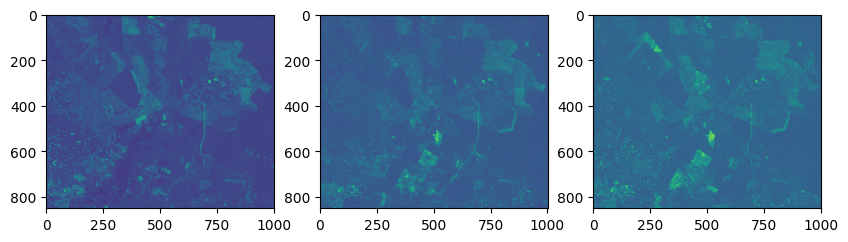

In [4]:
sat_image1=remove_clouds(LANDSAT_IMAGE1)
sat_image2=remove_clouds(LANDSAT_IMAGE2)
sat_image3=remove_clouds(LANDSAT_IMAGE3)
# Checking if the clouds are removed
fig,axs=plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(sat_image1[0])
axs[1].imshow(sat_image2[0])
axs[2].imshow(sat_image3[0])

### Identify pixels that got deforested

To identify which pixels in the sample data got deforested i will use unsupervised learning appraoch.  
clustering techniques such as kmeans are best suited (in my opinion) to segment the satellite image into deforested areas and not deforested areas

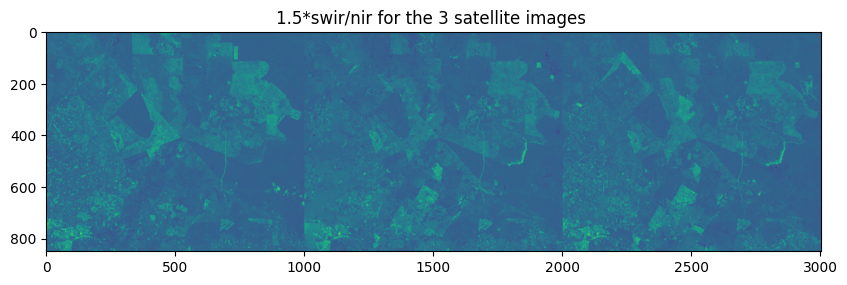

In [5]:
# Applying swir/nir ratio
# The SWIR/NIR ratio is a measure of the ratio of short-wave infrared (SWIR) radiation to near infrared (NIR) radiation. 
# This ratio is used to assess different types of vegetation and is important for vegetation monitoring. 
sat_image1_ratio=1.5*(sat_image1[5]/sat_image1[4])
sat_image2_ratio=1.5*(sat_image2[5]/sat_image2[4])
sat_image3_ratio=1.5*(sat_image3[5]/sat_image3[4])

plt.figure(figsize=(10,10))
plt.imshow(np.hstack((sat_image1_ratio,sat_image2_ratio,sat_image3_ratio)))
plt.title("1.5*swir/nir for the 3 satellite images ")
plt.show()

### Implementing Min Max Normalization
To be able to compare between the three sattelite images i will use Min-max normalization.  
For every feature, the minimum value of that feature gets transformed into a 0, the maximum value gets transformed into a 1, and every other value gets transformed into a decimal between 0 and 1.

In [6]:
def normalize(image:np.ndarray)-> np.ndarray:
    
    """Min-Max normalization implementation
    
     Args:
        image (np.ndarray): The satellite image
      

    Returns:
          numpy array
    """
    
    norm = (image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image))
    return norm

In [7]:
sat_image1_ratio=normalize(sat_image1_ratio)
sat_image2_ratio=normalize(sat_image2_ratio)
sat_image3_ratio=normalize(sat_image3_ratio)

### Applying Kmeans Image Segmentation

In [8]:
from sklearn.cluster import KMeans

# store satellite images in list and loop each image to segment
data = [sat_image1_ratio, sat_image2_ratio, sat_image3_ratio] 
for i in range(len(data)):
    h, w = data[i].shape
    pic_n = data[i].reshape(h * w, 1)
    # since we are trying to seperate the image into bare and forested areas, number of clusters will be 2
    kmeans = KMeans(n_clusters=3, max_iter=150, n_init="auto").fit(pic_n)

    pic2show = kmeans.cluster_centers_[kmeans.labels_]
    clustered_pic = pic2show.reshape(h, w)

    data[i] = normalize(clustered_pic)  # Replace the satellite image with the normalized and segmented version of it 

sat_image1_cluster,sat_image2_cluster,sat_image3_cluster=data

### Plotting segmented images

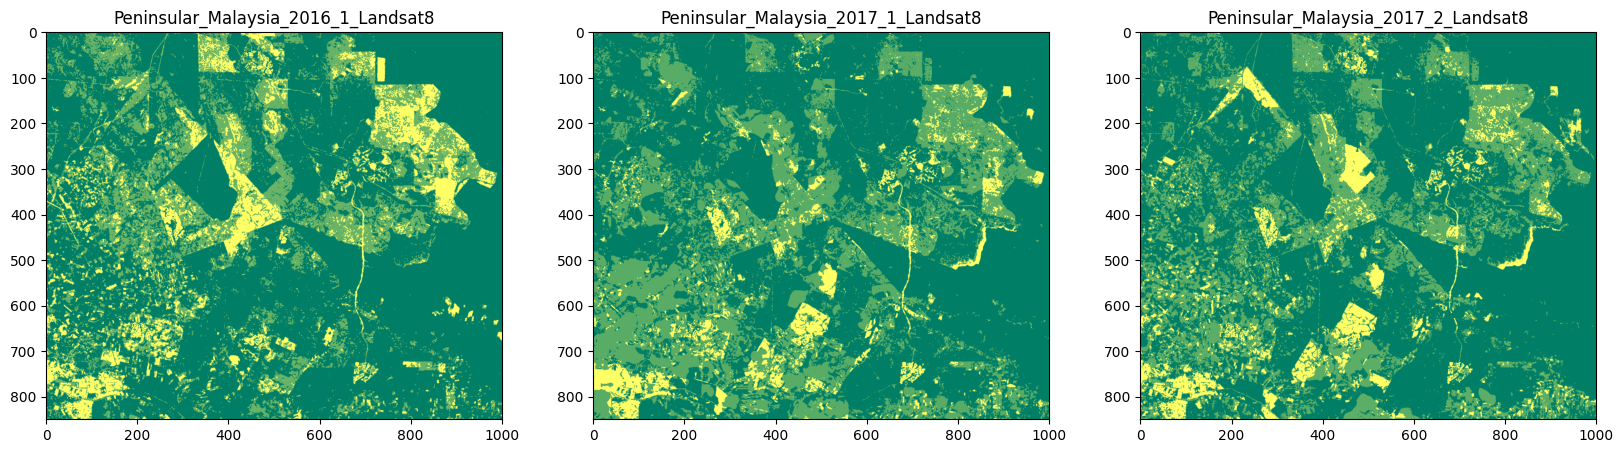

In [9]:
# Green parts in the plot are forested areas(has the value 1) and yellow parts are bare areas (has the value 0)
fig,axs=plt.subplots(1,3,figsize=(20,10))
axs[0].imshow(sat_image1_cluster,cmap="summer")
axs[0].set_title("Peninsular_Malaysia_2016_1_Landsat8")

axs[1].imshow(sat_image2_cluster,cmap="summer")
axs[1].set_title("Peninsular_Malaysia_2017_1_Landsat8")

axs[2].imshow(sat_image3_cluster,cmap="summer")
axs[2].set_title("Peninsular_Malaysia_2017_2_Landsat8")

plt.show()

### When Deforestation happened

To detect the deforestation time i will calculate values of forest areas (0) and bare areas (1) in the three images and visulaze the resulted data.  

Text(0.5, 1.0, 'Peninsular Malaysia Bare Areas Over time')

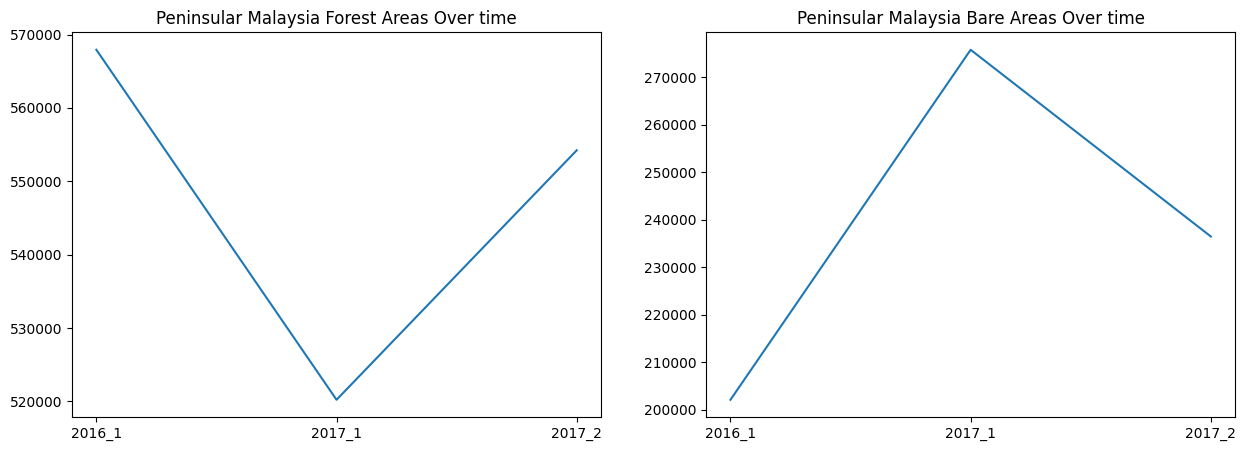

In [10]:
# Note that bare areas is 
import seaborn as sn
(unique, counts1) = np.unique(normalize(sat_image1_cluster), return_counts=True)
(unique, counts2) = np.unique(normalize(sat_image2_cluster), return_counts=True)
(unique, counts3) = np.unique(normalize(sat_image3_cluster), return_counts=True)
fig,axs=plt.subplots(1,2,figsize=(15,5))

axs[0].plot(["2016_1","2017_1","2017_2"],[counts1[0],counts2[0],counts3[0]])
axs[0].set_title("Peninsular Malaysia Forest Areas Over time")
axs[1].plot(["2016_1","2017_1","2017_2"],[counts1[1],counts2[1],counts3[1]])
axs[1].set_title("Peninsular Malaysia Bare Areas Over time")

From the results above it appears that deforestation happend 2016's First half. Which Sounds weired because i expected it will be 2017's second half

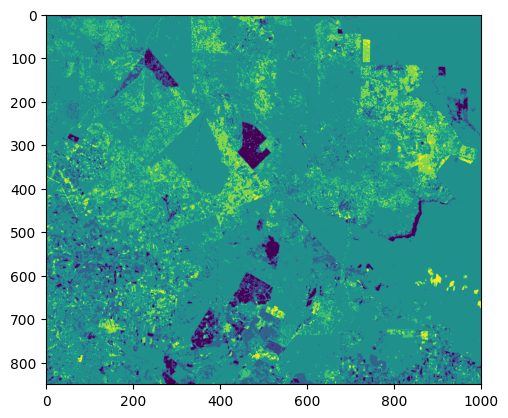

In [11]:
# plotting the difference happened between 2017_2 and 2016_1
# Yellow parts are the bare areas in 2016 and not in 2017
# Dark areas are the bare areas in 2017 and not in 2016
plt.imshow(sat_image1_cluster-sat_image3_cluster)

### Ways to improve my work 

1. Deep Learning approach such as U-net for segmentation can be more effective and wont hurt to try
2. The cloud removal implementation needs to be further optimized. Maybe using maps and list comprehension will reduce the time it takes to remove the clouds
3. Other Clustering Techniques can be explored such as DBscan and Mean Shift